# Quantum Fourier Transform (QFT)

This is the quantum implementation of the discrete Fourier Transform over the amplitudes of a wavefunction. It is part of many quantum algorithms, most notably Shor's factoring algorithm and quantum phase estimation (QPE).

## Intuition

Transforms between two bases, the computation (Z) basis and the Fourier basis. The H-gate is the single-qubit QFT, and it transforms between the Z-basis states |0> and |1> to the X-basis states |+> and |->. In the same way, all multi-qubit states in the computational basis have corresponding states in the Fourier basis.

### Counting the Fourier Basis

In the computational basis, we store numbers in binary using the states |0> and |1>

![z-basis-counting](https://qiskit.org/textbook/ch-algorithms/images/zbasis-counting.gif)

Note the frequency with which the different qubits change;
- The leftmost qubit flips with every increment in the number
- The next with every 2 increments
- The third with every 4 increments
- ...and so on...

In the Fourier basis, we store number usintg different rotations around the Z-axis:

![fourier-basis-counting](https://qiskit.org/textbook/ch-algorithms/images/fourierbasis-counting.gif)

The number we want to store dictates the angle at which each qubit is rotated around the Z-axis.

Note that the frequency with which each qubit changes, the leftmost qubit (`qubit=0`) has the lowest frequency, and the rightmost the highest (in this case)

## The Circuit that Implements the QFT

This makes use of two (2) gates. The first one is a single-qubit Hadamard gate, `H`, and the second is a two-qubit controller rotation `CROT`.

Given the two gates, a circuit that implements an n-qubit QFT is shown below

![qft-circuit](https://qiskit.org/textbook/ch-algorithms/images/qft.png)

This circuit operate as follows:

0. We state with an n-qubit input state |x_1 x_2 ... x_n>
1. After the first Hadamard gate on qubit 1, the state from the input state.
2. After the `UROT_2` gate on qubit 1 controlled by qubit 2, the state is transformed.
3. After the application of the last `UROT_n` gate on qubit1 controlled by qubit `n`, the state changes.
4. After the application of a similar sequence of gates for qubits 2 ... n, we find that the final state is exactly the QFT of the input state as derived, with the caveat that the order of the qubits is reversed in the output state.

### Form of the QFT Circuit

The example above demostrates a very useful form of the QFT for `N = 2^n`. Note that only the last qubit depends on the values of all the other input qubits and each further bit depends less and less on the input qubits. This becomes important in physical implementations of the QFT, where nearest-neighbor couplings are easier to achieve than distant couplings between the qubits.

Additionally, as the QFT circuit becomes large, an increasing amount of time is spent doing increasingly slight rotations. it turns out that we can ignore rotations below a certain threshold and still get decent results. This is knows as the approximate QFT. This is also important in physical implementations, as reducing the number of operations can greatly reduce decoherence and potential gate errors.

### Qiskit Implementation

The implementation of the `CROT` gate used in the discussion above is a controlled phase rotation gate.

#### Example on 3 Qubits

In [1]:
import numpy as np
from numpy import pi
# Aer is a high performance simulator for quantum circuits that includes noise models.
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

It is useful to work out the relevant code for the 3-qubit case before generalizing to the n-qubit case. First, we must define our quantum circuit:

In [2]:
qc = QuantumCircuit(3)

Qiskit's least significant bit has the lowest index (0), this the circuit will be mirrored through horizontally in relation to the image of the circuit that implements the QFT. First, we apply a H-gate to qubit 2:

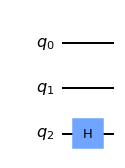

In [3]:
qc.h(2)
qc.draw()

We want to turn this an extra quarter turn if qubit 1 is in the state |1>

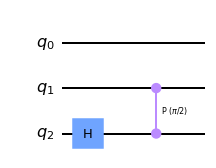

In [4]:
qc.cp((pi / 2), 1, 2) # CROT from qubit_1 to qubit_2
qc.draw()

And another eight turn if the least significant qubit (0) is |1>

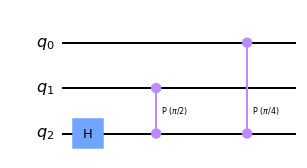

In [5]:
qc.cp((pi / 4), 0, 2) # CROT from qubit_2 to qubit_0
qc.draw()

With that qubit taken care of, we can now ignore it and repeat the process, using the same logic for qubits 0 and 1:

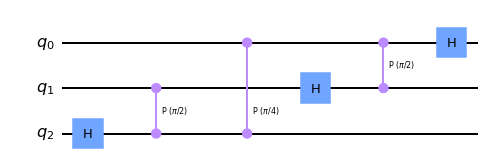

In [6]:
qc.h(1)
qc.cp((pi / 2), 0, 1) # CROT from qubit_0 to qubit_1
qc.h(0)
qc.draw()

Finally we must swap the qubits 0 and 2 to compelte the QFT:

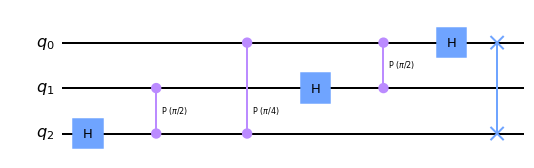

In [7]:
qc.swap(0, 2)
qc.draw()

#### General QFT Function

Let's create a general cirucit for the QFT in Qiskit. it is easier to build a circuit that implements the QFT with the qubit upside down, then swap them afterwards; we will start off by creating the function that rotates our qubits correctly.

Let's start as we did with the 3 qubit example, by correctly rotating the most significant qubit (the qubit with the highest index number)

In [8]:
def qft_rotations(qc, n):
    if n == 0: # Exit function if circuit is empty
        return qc
    n -= 1 # We start from index 0
    qc.h(n) # Apply the H-gate to the most significant qubit
    for qubit in range(n):
        # For each less significant qubit,
        # we need a smaller-angled controlled rotation:
        qc.cp((pi / (2 ** (n-qubit))), qubit, n)
    return n

Let's see how this looks like:

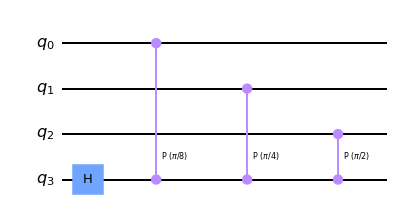

In [9]:
qc = QuantumCircuit(4)
qft_rotations(qc, 4)
qc.draw()

We can use the widget below to see how this circuit scales with the number of qubits in our circuit

In [10]:
from qiskit_textbook.widgets import scalable_circuit

scalable_circuit(qft_rotations)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\xfb\x00\x00\x01\x08\x08\x06\x00\x00\x00X\x8d]e\x…

We completed the first part of out QFT.
We have correctly rotated the most significant qubit, we need to correctly rotate the second most significant qubit.
We must deal with the thirdt most significal qubit too, and so on...

When we get to the end of our `qft_rotations()` function, we can use the same code to repeat the process on the next n-1 qubits

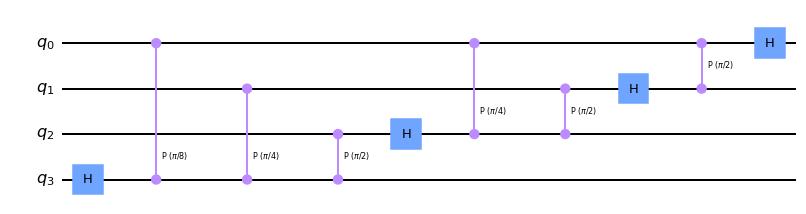

In [11]:
def qft_rotations_recursive(qc, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return qc
    n -= 1
    qc.h(n)
    for qubit in range(n):
        qc.cp((pi / (2 ** (n - qubit))), qubit, n)
    # We do recursion to call the function again for the next qubits
    qft_rotations_recursive(qc, n)
              
qc = QuantumCircuit(4)
qft_rotations_recursive(qc, 4)
qc.draw()

We can see again how this scales using the widget below:

In [12]:
scalable_circuit(qft_rotations_recursive)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\x19\x00\x00\x01\x08\x08\x06\x00\x00\x00\x1a\xcd,…

We need to add the swaps at the end of the QFT function to match the definition of the QFT. We will combine this into the final function `qft()`:

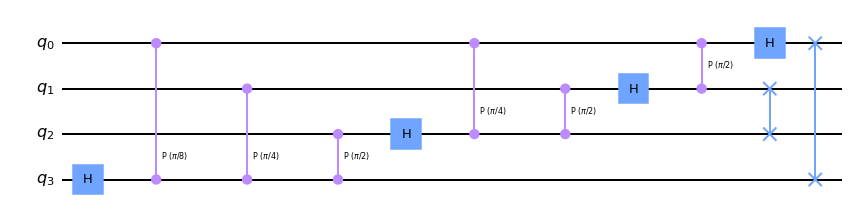

In [13]:
def swap_registers(qc, n):
    for qubit in range(n // 2):
        qc.swap(qubit, (n - qubit - 1))
    return qc

def qft(qc, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations_recursive(qc, n)
    swap_registers(qc, n)
    return qc

qc = QuantumCircuit(4)
qft(qc, 4)
qc.draw()

This is the generalised circuit for the quantum Fouriert transform. We can see again how this scales usign the widget below:

In [14]:
scalable_circuit(qft)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04U\x00\x00\x01\x08\x08\x06\x00\x00\x00\x9eK\xcbE\x…

To demostrat that this circuit works properly, we msut first encode a number in the computational basis.
We can see the number `5` in binary is `101`:

In [15]:
bin(5)

'0b101'

Let's enconde this into our qubits:

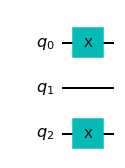

In [16]:
# Create the circuit
qc = QuantumCircuit(3)

# Encode the state `5`
qc.x(0)
qc.x(2)
qc.draw()

Let's check the qubit's states usign the aer simulator:

/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


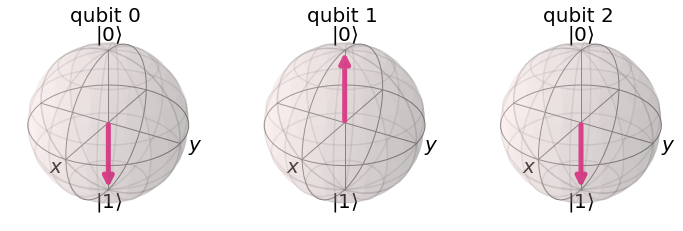

In [17]:
sim = Aer.get_backend("aer_simulator")

qc_init = qc.copy()
qc_init.save_statevector()

statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

Let's use our QFT function and view the final state of our qubits

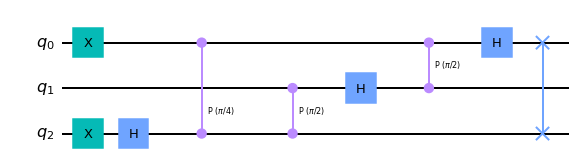

In [18]:
qft(qc, 3)
qc.draw()

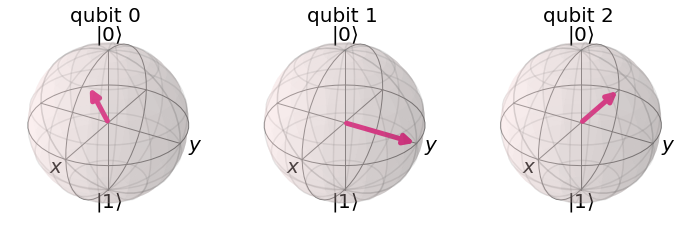

In [19]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

We can see out QFT function has worked correctly.

#### Running QFT on a Real Quantum Device

If we tried running the previous circuit on a real quantum device, the results would have been completely random, since all qubits are in equal superpositon of |0⟩ and |1⟩

If we want to demostrate and investigate the QFT working on a real hardware, we can instead create the state |5˜⟩ seen at the end of the previous section, adn run the QFT in reverse, and verify the output is the state |5⟩ as expected.

Let's use Qiskit to easily reverse our QFT operation:

In [20]:
def inverse_qft(qc, n):
    """Does the inverse QFT on the first n qubits in the quantum circuit (qc)"""
    # 1. Create a QFT circuit of the correct size
    qft_c = qft(QuantumCircuit(n), n)
    # 2. Take the inverse of this circuit
    inv_qft_c = qft_c.inverse()
    # 3. Add it to the first n qubits in our existing quantum cirucit (qc)
    qc.append(inv_qft_c, qc.qubits[:n])
    return qc.decompose() # .decompose() allows us to see the individual gates

Let's put our qubits in the state |5˜⟩

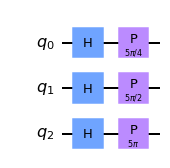

In [21]:
n_qubits = 3
num = 5
qc = QuantumCircuit(n_qubits)

for qubit in range(n_qubits):
    qc.h(qubit)

qc.p(((num * pi)/4), 0)
qc.p(((num * pi)/2), 1)
qc.p((num * pi), 2)

qc.draw()

We can see this does indeed results in the Fourier state |5˜⟩

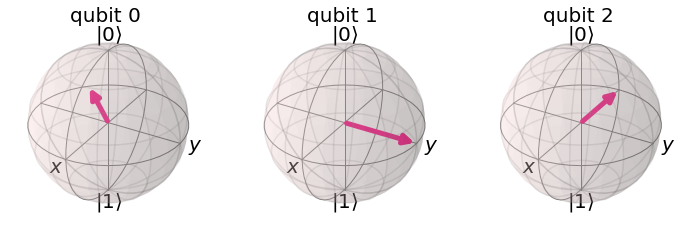

In [22]:
sim = Aer.get_backend("aer_simulator")

qc_init = qc.copy()
qc_init.save_statevector()

statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

Let's apply our inverse QFT

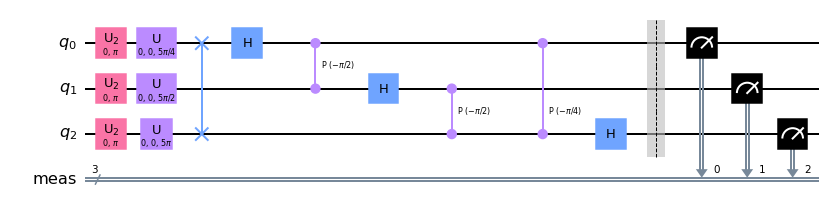

In [23]:
qc = inverse_qft(qc, n_qubits)
qc.measure_all()
qc.draw()

To be able to run this on a real quantum device, we must use our IBMQ accounts and get the least busy backend device with less than or equal to `n_qubits`

In [24]:
IBMQ.load_account()

def filters(x):
    ret = x.configuration().n_qubits >= n_qubits \
        and not x.configuration().simulator \
        and x.status().operational == True
    return ret


provider = IBMQ.get_provider(hub="ibm-q")
backend = least_busy(
    provider.backend(filters=filters)
)

print("Least busy backend: ", backend)

Traceback (most recent call last):
  Input In [24] in <cell line: 11>
    provider.backend(filters=filters)
TypeError: 'IBMQBackendService' object is not callable

Use %tb to get the full traceback.


In [ ]:
shots = 2048
transpiled_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(transpiled_qc, shots=shots)

job_monitor(job)

In [ ]:
counts = job.result().get_counts()
plot_historgram(counts)

We (hopefully) see that the highest probability outcome is `101`

## References

[1] M. Nielsen and I. Chuang, Quantum Computation and Quantum Information, Cambridge Series on Information and the Natural Sciences (Cambridge University Press, Cambridge, 2000).